#Imports

uncertainty checkpoints,
- split data to see equal distrubuion (insert the graph)
- do uncertaity for each type (length based, class based)
- give a general probability distrution graph for explanation purpose.
- take 5 graph for each class  and compare their most confident and least confident based on variance outcomes (total 8 images)
- for each type take best 5 predictions and worst 5 predictions based on mean

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import zipfile
from pathlib import Path
import random
import torchvision
from tqdm.auto import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

#https://github.com/eniac00/binary-dataset/raw/main/binary_datasets_512_15_2.zip


'cuda'

#Unzipping data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import requests
import zipfile
from pathlib import Path


data_path = Path("data/")
image_path = data_path /"proteins"

if image_path.is_dir():
  print(f"{image_path} directory already exists ")

else:
  print(f"{image_path} does not exist... creating one")
  image_path.mkdir(parents=True, exist_ok=True)


with zipfile.ZipFile(data_path / "/content/drive/MyDrive/Colab Notebooks/multipvp/binary_data.zip", "r") as zip_ref:
  print('unzipping proteins dataset')
  zip_ref.extractall(image_path)

data/proteins directory already exists 
unzipping proteins dataset


#Data Gathering
- Getting data from test samples for PVP and non-PVP which are in .png format

In [ ]:

pvp_path = Path('/content/data/proteins/test/PVP')
nonpvp_path = Path('/content/data/proteins/test/non-PVP')
pvp_list = []
nonpvp_list = []
for root, dirs, files in os.walk(pvp_path):
    for file in files:
        # Check for .fasta or .fa extension
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            pvp_list.append(full_path)


for root, dirs, files in os.walk(nonpvp_path):
    for file in files:
        # Check for .fasta or .fa extension
        if file.endswith('.png'):
            full_path = os.path.join(root, file)
            nonpvp_list.append(full_path)


print('Len of pvp: ', len(pvp_list))
print('Len of nonpvp: ', len(nonpvp_list))

Len of pvp:  10564
Len of nonpvp:  14065


# Getting data for long and short sequences
- PVP > 350 is long
- PVP <= 350 is short
- non-PVP > 275 is long
- non-PVP <= is short

In [ ]:
random.seed(42)
random.shuffle(pvp_list)
random.shuffle(nonpvp_list)

pvp_less_350 = []
pvp_greater_350 = []

for each in pvp_list:

  if int(str(each).split('_')[-1].split('.')[0])<=350:
    if len(pvp_less_350)!=100:
      pvp_less_350.append(each)
  else:
    if len(pvp_greater_350)!=100:
      pvp_greater_350.append(each)

nonpvp_less_275 = []
nonpvp_greater_275 = []

for each in nonpvp_list:

  if int(str(each).split('_')[-1].split('.')[0])<=275:
    if len(nonpvp_less_275)!=100:
      nonpvp_less_275.append(each)
  else:
    if len(nonpvp_greater_275)!=100:
      nonpvp_greater_275.append(each)

print('length of pvp_less_350: ', len(pvp_less_350))
print('length of pvp_greater_350: ', len(pvp_greater_350))
print('length of nonpvp_less_275: ', len(nonpvp_less_275))
print('length of nonpvp_greater_275: ', len(nonpvp_greater_275))

# pvp_less_350[0]

length of pvp_less_350:  100
length of pvp_greater_350:  100
length of nonpvp_less_275:  100
length of nonpvp_greater_275:  100


'/content/data/proteins/test/PVP/YP_009789331.1_len_190.png'

#Making dataloader

In [ ]:
# from torchvision import datasets

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# manual_tranforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), normalize])
# pvp_less_data = datasets.ImageFolder(root='/content/uncertainty',
#                                   transform = manual_tranforms,
#                                   target_transform=None)

#Model loading
- The model GoogleNet was trained on our training data and saved, which is then loaded below and used for for uncertainty analysis.

In [ ]:
# # weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
# # model = torchvision.models.efficientnet_v2_s(weights=weights).to(device)
# # model
# weights = torchvision.models.GoogLeNet_Weights.DEFAULT
# model = torchvision.models.googlenet(weights=weights).to(device)
# from torch import nn

# model.fc = nn.Linear(in_features=1024, out_features=2, bias=True).to(device)
# model.dropout = nn.Dropout(0.2)
# model

In [ ]:
from pathlib import Path

# #LOad model and get the saved dict()
MODEL_SAVE_PATH = Path('/content/drive/MyDrive/Colab Notebooks/multipvp/googlenet_binary_89.pth')
model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model.to(device)

#Transform - image transformations applied before classification

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
manual_tranforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(),normalize])

In [ ]:
pvp_less_350[6]
# nonpvp_less_275[0]

'/content/data/proteins/test/PVP/YP_009007685.1_len_278.png'

# Testing is model is loaded correctly

In [ ]:


test_image = '/content/data/proteins/test/PVP/YP_009615909.1_len_247.png'
image = Image.open(test_image)
transformed_image = manual_tranforms(image)
transformed_image = transformed_image.unsqueeze(0)


model.eval()
with torch.no_grad():
    output = model(transformed_image.to(device))
predicted_probabilities = torch.softmax(output, dim=1)

predicted_probabilities

tensor([[0.9908, 0.0092]], device='cuda:0')

#Helper functions
- Calculate_statistics_and_visualize function calculates mean and standard deviation from predictions
- Class analysis function calculates the list of means and standard deviations of predicitons for each images (each image was predicted 50 times)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_statistics_and_visualize(data):

    # Convert the list to a NumPy array for efficient computation
    data_array = np.array(data)

    # Calculate mean and standard deviation
    mean = np.mean(data_array)
    std_dev = np.std(data_array)
    # print('std_dev is ',std_dev)
    return mean, std_dev


In [ ]:


def class_analysis(target_list,idx):

  mean_lis = []
  std_lis = []
  # entropy_lis = []
  for each in tqdm(range(len(target_list))):


    image_path = target_list[each]
    image = Image.open(image_path)

    transformed_image = manual_tranforms(image)
    transformed_image = transformed_image.unsqueeze(0)
    predictions = []

    model.train()
    with torch.inference_mode():
      for a in range(50):
        logits = model(transformed_image.to(device))
        preds = torch.softmax(logits, dim=1)
        # print('here1 is - ',preds)
        b = preds.squeeze(0)
        # print('here2 is - ',a)
        predictions.append(b[idx].cpu())
    # entropy = calculate_entropy(predictions)
      mean, std_dev = calculate_statistics_and_visualize(predictions)
      mean_lis.append(mean)
      std_lis.append(std_dev)
    # entropy_lis.append(entropy)
  return mean_lis, std_lis





In [ ]:
# (0.0072731273248791695)**0.5

0.08528263202363755

In [ ]:
def avg_mean_std(mean,std,lis_name):

  m = np.array(mean)
  std = np.array(std)
  var = (std.mean())**0.5
  # print('std is ',std)
  print(f'Average mean of {lis_name} is {m.mean()}')
  print(f'Average std of {lis_name} is {std.mean()}')
  print(f'Variance of {lis_name} is {var}')


In [ ]:
items = ['PVP','non-PVP']

#Single image prediction

In [ ]:
import math
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt


def calculate_entropy(prob):
    if prob != 1.0:
        ent = (prob * math.log2(1 / prob)) + ((1 - prob) * math.log2(1 / (1 - prob)))
        return ent

def single_image_analyze(image_path, cat, save_path=None):
    image = Image.open(image_path)
    transformed_image = manual_tranforms(image)
    transformed_image = transformed_image.unsqueeze(0)

    predictions = []
    model.train()

    with torch.inference_mode():
        for a in range(100):
            logits = model(transformed_image.to(device))
            preds = torch.softmax(logits, dim=1)
            b = preds.squeeze(0)
            predictions.append(b[cat].cpu())

    # Convert the list to a NumPy array for efficient computation
    data_array = np.array(predictions)

    # Calculate mean and standard deviation
    mean = np.mean(data_array)
    entropy = calculate_entropy(mean)
    std_dev = np.std(data_array)

    # Plotting the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(data_array, bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f'{items[cat]} (short)')
    plt.xlabel('Softmax score')
    plt.ylabel('Sample Predictions')
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean + 1 SD: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean - 1 SD: {mean - std_dev:.2f}')
    plt.legend()

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# single_image_analyze('path/to/your/image.jpg', cat=0, save_path='path/to/save/plot.png')


#view

#PVP 5 sampeles

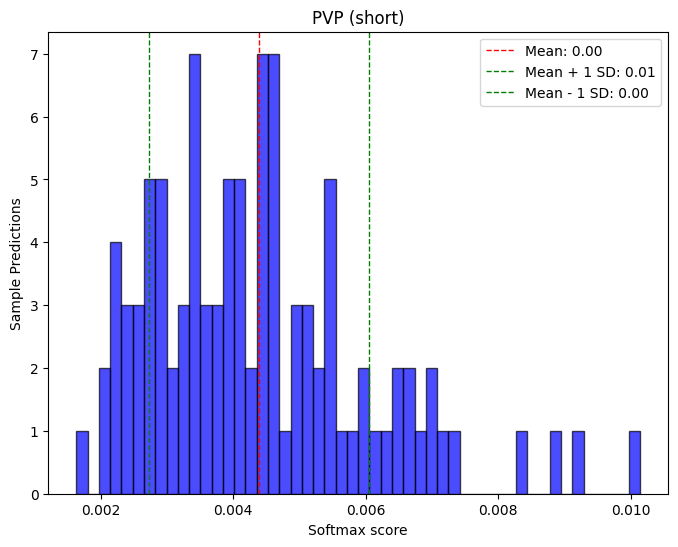

In [ ]:

single_image_analyze(pvp_less_350[0],0,'/content/drive/MyDrive/Colab Notebooks/multipvp/pvp_images/img1.png')  #eval mode


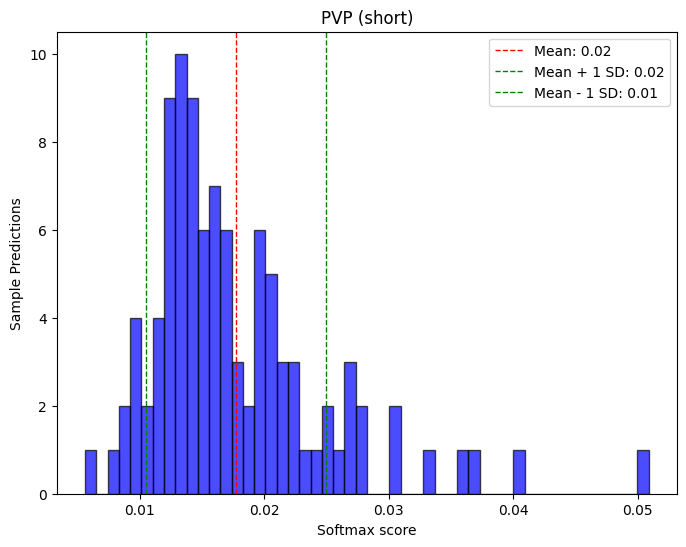

In [ ]:

single_image_analyze(pvp_less_350[1],0,'/content/drive/MyDrive/Colab Notebooks/multipvp/pvp_images/img2.png')  #eval mode


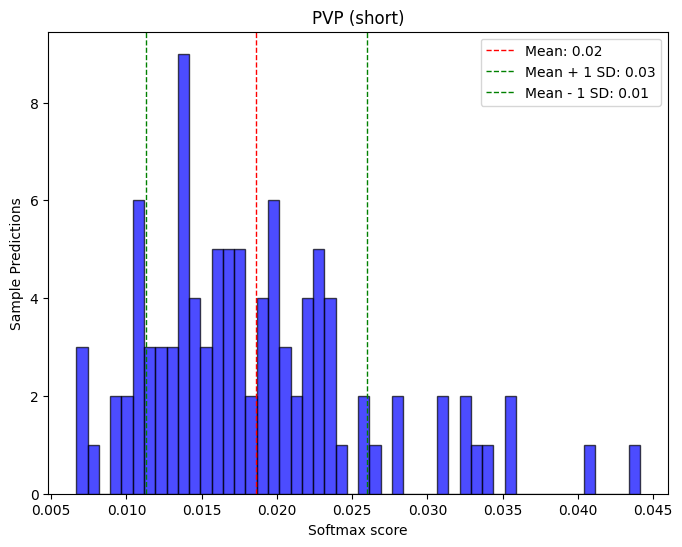

In [ ]:
single_image_analyze(pvp_less_350[std2.index(min(std2))],0,'/content/drive/MyDrive/Colab Notebooks/multipvp/pvp_images/img3.png')

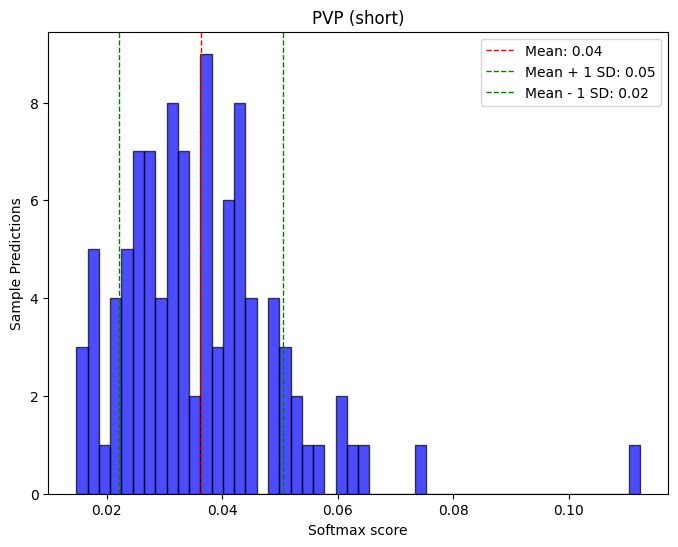

In [ ]:
single_image_analyze(pvp_less_350[mean2.index(max(mean2))],0,'/content/drive/MyDrive/Colab Notebooks/multipvp/pvp_images/img4.png')

#non-pvp 5 samples

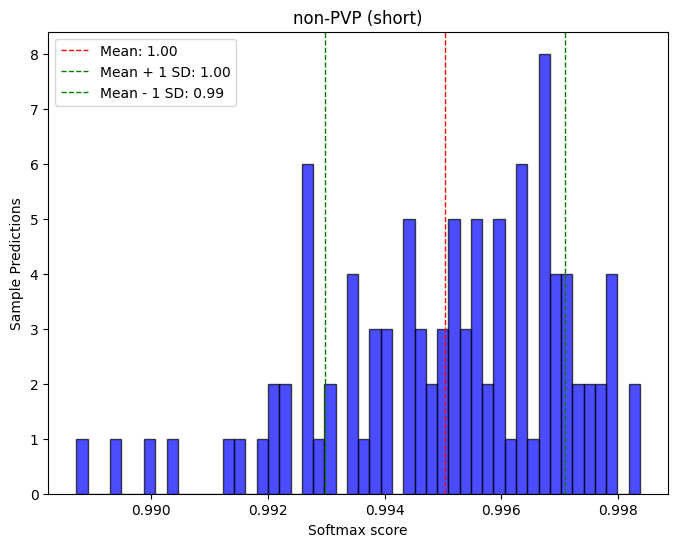

In [ ]:
single_image_analyze(nonpvp_less_275[std4.index(min(std4))],1, '/content/drive/MyDrive/Colab Notebooks/multipvp/nonpvp_images/img1.png')

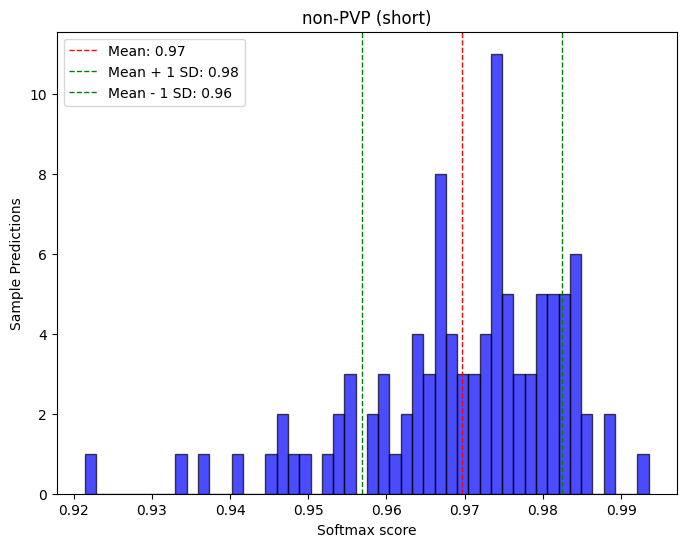

In [ ]:
single_image_analyze(nonpvp_less_275[56],1,'/content/drive/MyDrive/Colab Notebooks/multipvp/nonpvp_images/img2.png')

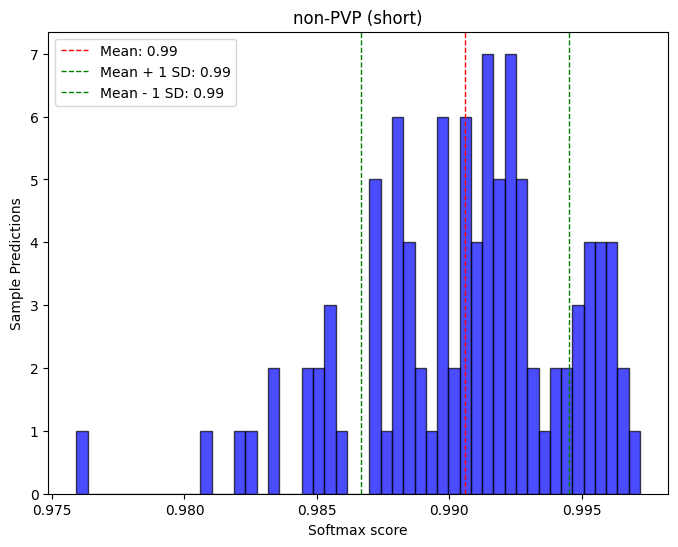

In [ ]:
single_image_analyze(nonpvp_less_275[98],1,'/content/drive/MyDrive/Colab Notebooks/multipvp/nonpvp_images/img3.png')  #eval mode

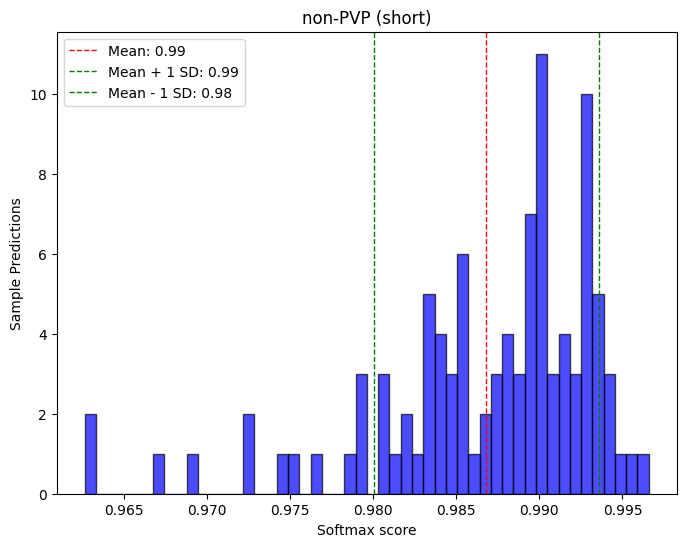

In [ ]:
single_image_analyze(nonpvp_less_275[5],1,'/content/drive/MyDrive/Colab Notebooks/multipvp/nonpvp_images/img4.png') #eval mode

#end

#Results

In [ ]:
mean1, std1 = class_analysis(pvp_less_350,0)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
avg_mean_std(mean1,std1,'pvp_less_350')

Average mean of pvp_less_350 is 0.017085272818803787
Average std of pvp_less_350 is 0.006727147847414017
Variance of pvp_less_350 is 0.08201919194562951


In [ ]:
mean2, std2 = class_analysis(pvp_greater_350,0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
avg_mean_std(mean2,std2,'pvp_greater_350')

Average mean of pvp_greater_350 is 0.02105090767145157
Average std of pvp_greater_350 is 0.008458198048174381
Variance of pvp_greater_350 is 0.09196846224752472


In [ ]:
mean3, std3 = class_analysis(nonpvp_greater_275,1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
avg_mean_std(mean3,std3,'nonpvp_less_275')

Average mean of nonpvp_less_275 is 0.9877812266349792
Average std of nonpvp_less_275 is 0.00503484858199954
Variance of nonpvp_less_275 is 0.07095666693130069


In [ ]:
mean4, std4 = class_analysis(nonpvp_less_275,1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
avg_mean_std(mean4,std4,'nonpvp_less_275')

Average mean of nonpvp_less_275 is 0.9870733618736267
Average std of nonpvp_less_275 is 0.005263575818389654
Variance of nonpvp_less_275 is 0.07255050529382724


In [ ]:
(0.002401000587269664)**0.5

0.049000005992547224

# For MCD 0.1 on the model

- pvp less than 350 : \
Average mean of pvp_less_350 is 0.017535490915179253 \
Average std of pvp_less_350 is 0.004626351408660412

- pvp greater than 350 : \
Average mean of pvp_greater_350 is 0.02031843177974224 \
Average std of pvp_greater_350 is 0.005295093636959791

- nonpvp less than 275 : \
Average mean of nonpvp_less_275 is 0.9867517948150635 \
Average std of nonpvp_less_275 is 0.0034977763425558805

- nonpvp greater than 275 : \
Average mean of nonpvp_less_275 is 0.9863763451576233 \
Average std of nonpvp_less_275 is 0.0035937875509262085


# For MCD 0.2 on the model

- pvp less than 350 : \
Average mean of pvp_less_350 is 0.01828889548778534 \
Average std of pvp_less_350 is 0.007324965205043554

- pvp greater than 350 : \
Average mean of pvp_greater_350 is 0.021099166944622993 \
Average std of pvp_greater_350 is 0.008316176943480968

- nonpvp less than 275 : \
Average mean of nonpvp_less_275 is 0.9859197735786438 \
Average std of nonpvp_less_275 is 0.005708306562155485

- nonpvp greater than 275 : \
Average mean of nonpvp_less_275 is 0.9857237935066223 \
Average std of nonpvp_less_275 is 0.005873146466910839

# For MCD 0.05 on the model

- pvp less than 350 : \
Average mean of pvp_less_350 is 0.0172299575060606 \
Average std of pvp_less_350 is 0.0030657576862722635
- pvp greater than 350 : \
Average mean of pvp_greater_350 is 0.019836224615573883 \
Average std of pvp_greater_350 is 0.0035125508438795805
- nonpvp less than 275 \
Average mean of nonpvp_less_275 is 0.9870141744613647 \
Average std of nonpvp_less_275 is 0.0023620305582880974
- nonpvp greater than 275 \
Average mean of nonpvp_less_275 is 0.9866258502006531 \
Average std of nonpvp_less_275 is 0.002401000587269664